In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load and limit data
data = pd.read_csv(r'C:\grad_sem2\ML\Project\weather_food_delivery\data\master_delivery_data.csv')
data = data.sample(n=20000, random_state=42)  # Use 5000 rows for speed

# Encode categorical columns
categorical_cols = ['restaurant_name', 'city', 'cuisine']
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# Set target and features
target_col = 'has_delivery'
X = data.drop([target_col, 'restaurant_id'], axis=1)
y = data[target_col]

# Impute missing values for X only
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Concatenate and drop any row with NaN in features or target
df = pd.concat([X_imputed, y], axis=1)
df_clean = df.dropna()
X_clean = df_clean.drop(target_col, axis=1)
y_clean = df_clean[target_col]

# Train/test split (stratify to preserve class ratio in test set)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# Handle class imbalance in training set with SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("After SMOTE oversampling:")
print(y_train_bal.value_counts(normalize=True))

After SMOTE oversampling:
has_delivery
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [2]:
print("=== Sample of SMOTE-Balanced Training Data ===")
display(X_train_bal.head(5).assign(has_delivery=y_train_bal.head(5).values))

print("\n=== Sample of Test Data ===")
display(X_test.head(5).assign(has_delivery=y_test.head(5).values))

=== Sample of SMOTE-Balanced Training Data ===


,restaurant_name,city,cuisine,latitude,longitude,has_takeaway,has_opening_hours,temperature_F,precipitation,humidity,wind_speed,has_delivery
0,7182.0,3.0,833.0,40.716961,-73.958835,0.0,1.0,35.0,0.0,54.000000,16.021547,0.0
1,1047.0,2.0,502.0,34.022358,-118.292170,0.0,0.0,50.0,0.0,89.000000,16.021547,0.0
2,1499.0,3.0,147.0,40.756369,-73.928987,0.0,0.0,34.0,0.0,65.668508,16.021547,0.0
3,4299.0,3.0,557.0,40.727323,-73.999788,1.0,1.0,33.0,19.0,56.000000,16.021547,1.0
4,1356.0,1.0,226.0,29.830003,-95.380226,0.0,0.0,58.0,0.0,90.000000,16.021547,0.0



=== Sample of Test Data ===


,restaurant_name,city,cuisine,latitude,longitude,has_takeaway,has_opening_hours,temperature_F,precipitation,humidity,wind_speed,has_delivery
256654,5883.0,3.0,10.0,40.773423,-73.955680,0.0,1.0,37.0,0.0,70.0,16.021547,0.0
808936,1214.0,0.0,595.0,41.918048,-87.645697,0.0,0.0,43.0,0.0,36.0,44.448000,0.0
1046068,3991.0,4.0,719.0,33.378040,-112.172797,0.0,0.0,47.0,0.0,54.0,16.021547,0.0
720378,4383.0,2.0,463.0,34.102055,-118.330935,0.0,0.0,52.0,0.0,89.0,3.704000,0.0
295141,3089.0,3.0,647.0,40.793785,-73.970796,0.0,1.0,42.0,0.0,57.0,27.780000,0.0


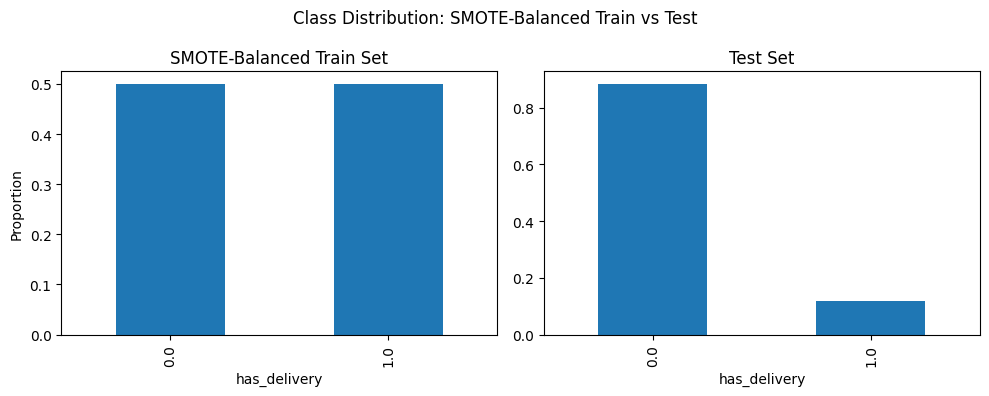

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,4))
y_train_bal.value_counts(normalize=True).plot(kind='bar', ax=axs[0], title='SMOTE-Balanced Train Set')
y_test.value_counts(normalize=True).plot(kind='bar', ax=axs[1], title='Test Set')
axs[0].set_xlabel('has_delivery')
axs[1].set_xlabel('has_delivery')
axs[0].set_ylabel('Proportion')
plt.suptitle('Class Distribution: SMOTE-Balanced Train vs Test')
plt.tight_layout()
plt.show()

Kernel: linear, C: 0.1, Accuracy: 0.931
Kernel: linear, C: 1, Accuracy: 0.931
Kernel: linear, C: 10, Accuracy: 0.932
Kernel: poly, C: 0.1, Accuracy: 0.883
Kernel: poly, C: 1, Accuracy: 0.883
Kernel: poly, C: 10, Accuracy: 0.883
Kernel: rbf, C: 0.1, Accuracy: 0.883
Kernel: rbf, C: 1, Accuracy: 0.883
Kernel: rbf, C: 10, Accuracy: 0.883


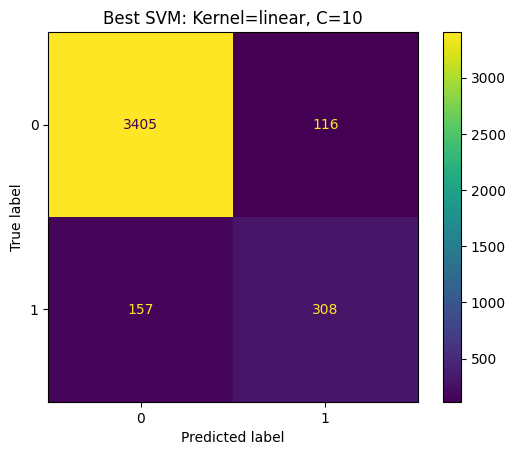

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

kernels = ['linear', 'poly', 'rbf']
costs = [0.1, 1, 10]
results = {}

for kernel in kernels:
    for C in costs:
        clf = SVC(kernel=kernel, C=C, degree=2 if kernel == 'poly' else 3, gamma='scale', random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        results[(kernel, C)] = (acc, cm)
        print(f"Kernel: {kernel}, C: {C}, Accuracy: {acc:.3f}")

# Visualize the best confusion matrix
best = max(results.items(), key=lambda x: x[1][0])
ConfusionMatrixDisplay(best[1][1]).plot()
plt.title(f'Best SVM: Kernel={best[0][0]}, C={best[0][1]}')
plt.show()

Random Forest Accuracy: 0.967


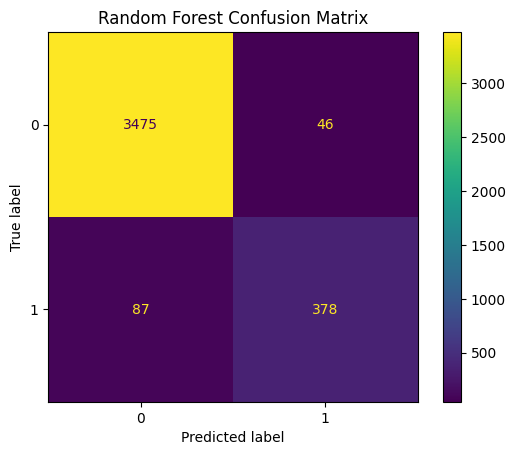

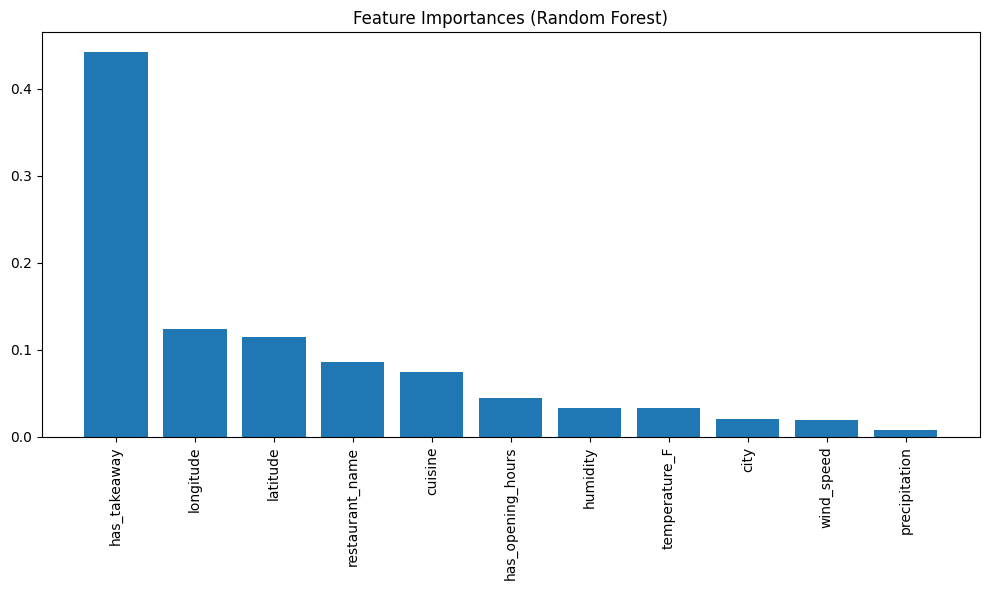

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f'Random Forest Accuracy: {acc_rf:.3f}')
ConfusionMatrixDisplay(cm_rf).plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

# Feature Importance
import numpy as np
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay



C:\Users\rishe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Results:
              precision    recall  f1-score   support

         0.0      0.971     0.951     0.961      3521
         1.0      0.679     0.787     0.729       465

    accuracy                          0.932      3986
   macro avg      0.825     0.869     0.845      3986
weighted avg      0.937     0.932     0.934      3986



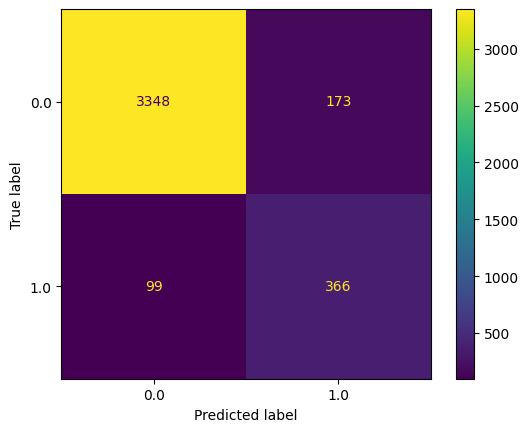

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)
ada.fit(X_train_bal, y_train_bal)
y_pred_ada = ada.predict(X_test)

print("AdaBoost Results:")
print(classification_report(y_test, y_pred_ada, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ada)

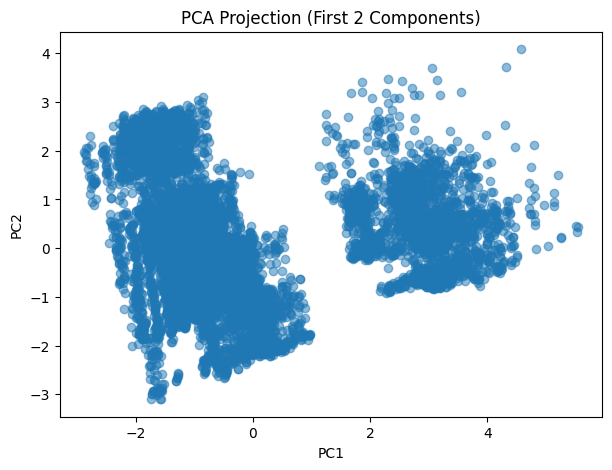

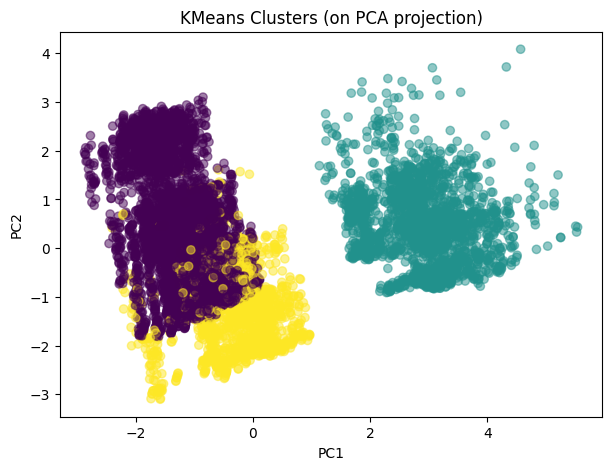

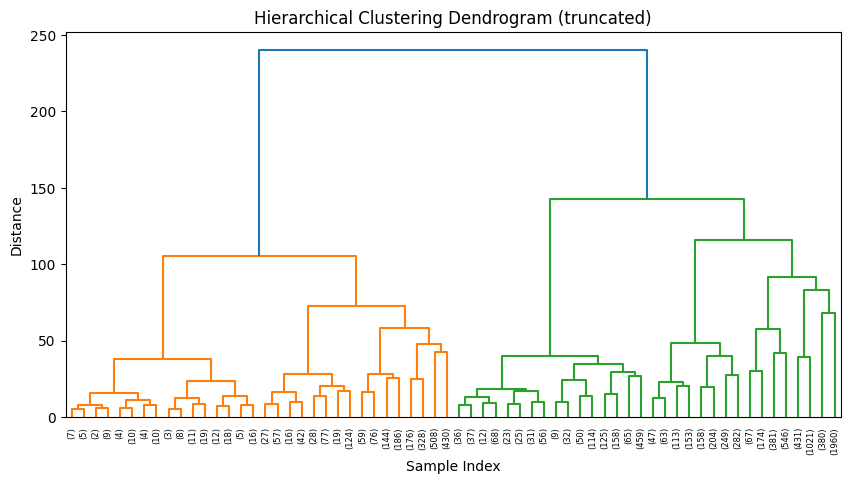

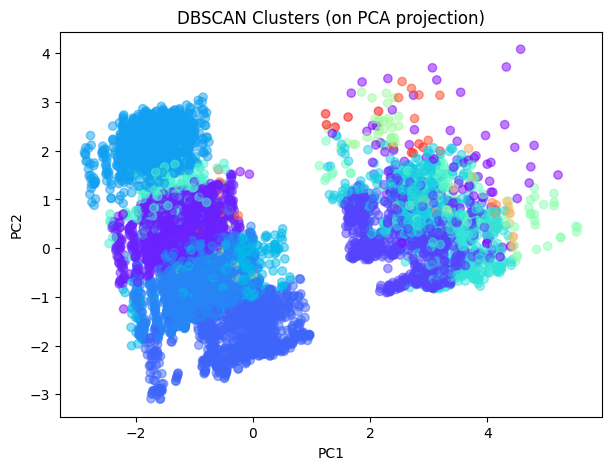

C:\Users\rishe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rishe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


                 Model  Accuracy  Precision    Recall  F1 Score
0       Multinomial NB  0.923771   0.631944  0.798246  0.705426
1         Bernoulli NB  0.834504   0.400000  0.894737  0.552846
2          Gaussian NB  0.761284   0.315476  0.929825  0.471111
3  Logistic Regression  0.925777   0.640845  0.798246  0.710938
4        Decision Tree  0.937813   0.722222  0.741228  0.731602
5             AdaBoost  0.935306   0.689655  0.789474  0.736196


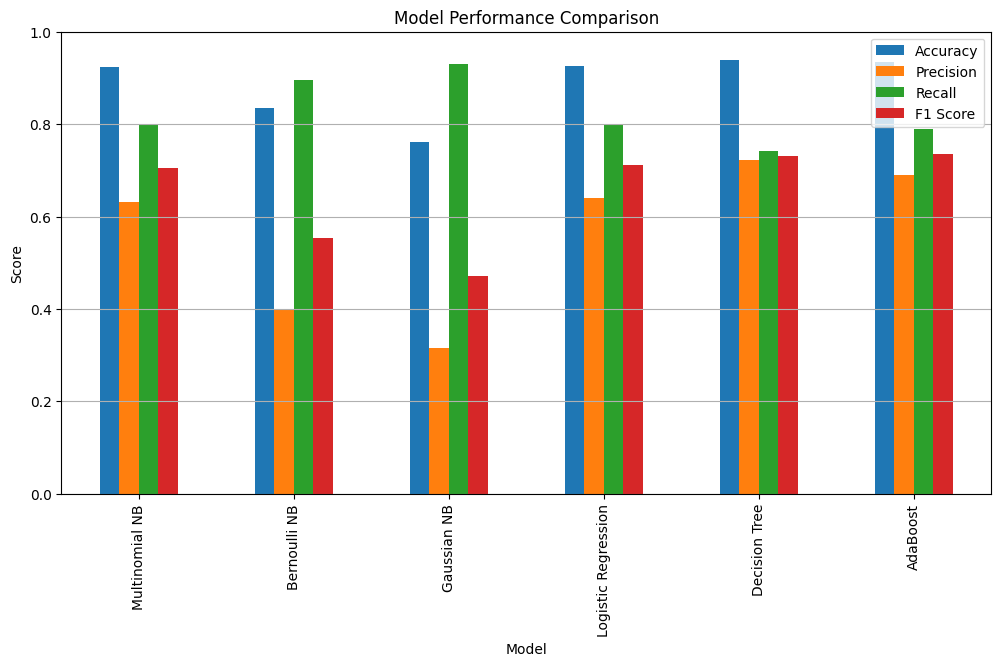

In [6]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Unsupervised learning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

# Classification
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 2. Load Data (limit to 10,000 rows)
data = pd.read_csv(r'C:\grad_sem2\ML\Project\weather_food_delivery\data\master_delivery_data.csv')
data = data.sample(n=10000, random_state=42)

# 3. Encode Categorical Columns
categorical_cols = ['restaurant_name', 'city', 'cuisine']
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# 4. Set Features and Target
target_col = 'has_delivery'
X = data.drop([target_col, 'restaurant_id'], axis=1)
y = data[target_col]

# 5. Impute Missing Values (features only)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# 6. Drop any rows with NaN in features or target
df = pd.concat([X_imputed, y], axis=1)
df_clean = df.dropna()
X_clean = df_clean.drop(target_col, axis=1)
y_clean = df_clean[target_col]

# 7. Unsupervised Learning (2_ML.ipynb)
# --- PCA ---
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X_clean)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_pca)
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title("PCA Projection (First 2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# --- KMeans ---
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled_pca)
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_kmeans, cmap='viridis', alpha=0.5)
plt.title("KMeans Clusters (on PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# --- Hierarchical Clustering ---
linked = linkage(X_scaled_pca, 'ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# --- DBSCAN ---
dbscan = DBSCAN(eps=2, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled_pca)
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_dbscan, cmap='rainbow', alpha=0.5)
plt.title("DBSCAN Clusters (on PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 8. Train/Test Split (stratify to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# 9. Handle Class Imbalance in Training Set with SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 10. Multinomial NB (requires non-negative features)
scaler_mn = MinMaxScaler()
X_train_mn = scaler_mn.fit_transform(X_train_bal)
X_test_mn = scaler_mn.transform(X_test)

mn_nb = MultinomialNB()
mn_nb.fit(X_train_mn, y_train_bal)
y_pred_mn = mn_nb.predict(X_test_mn)

# 11. Bernoulli NB (requires binary features)
X_train_bn = (X_train_bal > X_train_bal.mean()).astype(int)
X_test_bn = (X_test > X_train_bal.mean()).astype(int)
bn_nb = BernoulliNB()
bn_nb.fit(X_train_bn, y_train_bal)
y_pred_bn = bn_nb.predict(X_test_bn)

# 12. Gaussian NB
gnb = GaussianNB()
gnb.fit(X_train_bal, y_train_bal)
y_pred_gn = gnb.predict(X_test)

# 13. Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_bal, y_train_bal)
y_pred_log = logreg.predict(X_test)

# 14. Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_bal, y_train_bal)
y_pred_dt = dt.predict(X_test)

# 15. AdaBoost
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)
ada.fit(X_train_bal, y_train_bal)
y_pred_ada = ada.predict(X_test)

# 16. Create Summary Table
results = [
    {"Model": "Multinomial NB", "y_true": y_test, "y_pred": y_pred_mn},
    {"Model": "Bernoulli NB", "y_true": y_test, "y_pred": y_pred_bn},
    {"Model": "Gaussian NB", "y_true": y_test, "y_pred": y_pred_gn},
    {"Model": "Logistic Regression", "y_true": y_test, "y_pred": y_pred_log},
    {"Model": "Decision Tree", "y_true": y_test, "y_pred": y_pred_dt},
    {"Model": "AdaBoost", "y_true": y_test, "y_pred": y_pred_ada}
]

summary = []
for res in results:
    acc = accuracy_score(res["y_true"], res["y_pred"])
    prec = precision_score(res["y_true"], res["y_pred"], zero_division=0)
    rec = recall_score(res["y_true"], res["y_pred"], zero_division=0)
    f1 = f1_score(res["y_true"], res["y_pred"], zero_division=0)
    summary.append({
        "Model": res["Model"],
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

df_summary = pd.DataFrame(summary)
print(df_summary)

# 17. Plot Comparison
df_summary.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot.bar(figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()